# Data

**MV104 police reported crash database**
* Based on MV104 crash report filled out by a police officer at the time of a crash
* Reports sent to NY State DMV to compile into a database
* Three tables: Crash table, Person table, and Vehicle table, linked by common identifiers.
* NY State DMV has the three tables ([crash](https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Case-Information-Three-Year-/e8ky-4vqe), [person](https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Individual-Information-Three/ir4y-sesj), [vehicle](https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Vehicle-Information-Three-Ye/xe9x-a24f)) on NY Open Data, but does not include the common identifiers needed to link the datasets together.

MV104 reports are filled out by NYPD officers responding to a crash. The reports are sent to the state DMV who compiles the data into a database. It is then sent to the state DOT who geocodes the crash location and sends it to NYC DOT.

![Data Flow](img/MV104DataFlow.jpg)

**Hospital records data**
* Hospital administrative records were obtained from NY SPARCS (Statewide Planning and Research Cooperative System).
* Time period: 2011 - 2013 (Billing code changes prior to 2011 made using earlier data infeasible. Post 2013 hospital data was not available at the time.)
* Injury Severity Score derived from patient records using the Barell matrix formula. (b-ISS). 

DOHMH used hospital administrative data on each patient to determine an injury severity score using the [Barell Matrix method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2564435/) .  The Barell Matrix is a classification system to translate billing codes into a matrix of injury types. These groupings are given an [Abbreviated Injury Scale (AIS) code](https://en.wikipedia.org/wiki/Abbreviated_Injury_Scale) ranging from 1 to 6 ( from minor injury to death).  Patients have an AIS for each injury, these are combined into one overall [Injury Severity Score (ISS)](https://en.wikipedia.org/wiki/Injury_Severity_Score) by taking the top three AIS from different body regions, squaring them and summing.

**Linked Police Reports and Hospital data**

In 2017 DOHMH linked police crash report data with hospital data. [Reference: Conderino, S, Fung, L  et al. “Linkage of traffic crash and hospitalization records with limited identifiers for enhanced public health surveillance” AA&P 2017.] About half the hospitalizations and ER visits related to traffic crashes were able to be matched to an MV104 crash report. They used a probabilistic matching method based on person level attributes (age, sex, crash role, collision type, date and time of crash, injury type, injury body location, and county). The time period was 2011 - 2013 (Billing code changes prior to 2011 made using earlier data infeasible. Post 2013 hospital data was not available at the time.)


![DataVenn](img/DataVenn.jpg)

This gave us a valuable dataset to start our analysis. The rest of this notebook explores the data in the linked dataset as well as the larger crash database. 

In [1]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import databuild as db
import sys
sys.path.insert(0,'/home/deena/Documents/data_munge/ModaCode/')
import moda

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()

# reorganize into pedestrian/bicyclist 1-veh crashes
ped = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()

# included biss data from linked onto ped (dropping anything not in linked)
ped = db.mergeBiss(ped,linked)

#format and categorize variables
ped = db.formatVars(ped)

print 'linked ped',ped.shape

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


full crash table (522108, 26)
full person table (1502797, 22)
full vehicle table (1092922, 20)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,9,20,25,35,48,54,58,63,65,85,89,102,126,128,129,138) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pedestrians/bicyclists (police reported) (single vehicle) (95292, 80)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
linked ped (17624, 106)


In [3]:
crash.date.min(),crash.date.max()

(Timestamp('2007-01-01 00:00:00'), Timestamp('2013-12-31 00:00:00'))

In [4]:
# police reported crashes
crashPR = crash[crash.POL_REPT=='Y']
indPR = ind[ind.CS_ID.isin(crashPR.CS_ID)&(~ind.INJT_ID.isin(['16','17','18']))]
crashPR = crashPR[crashPR.CS_ID.isin(indPR.CS_ID)]

print crash.shape
print crashPR.shape

(522108, 26)
(371958, 26)


## Police Reported Crashes - number per day

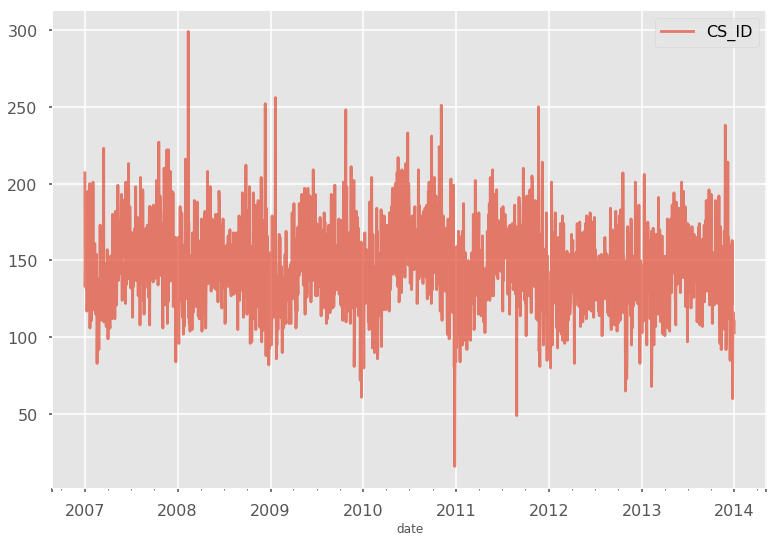

In [5]:
# police reported crashes
crashPR.groupby('date').count()[['CS_ID']].plot(alpha=.7)

## People involved in police reported crashes
* by role
* by injury severity (KABCO)

In [6]:
# format the variables for easier analysis
base = indPR.merge(crash.drop(['RDSYST_ID'],axis=1),
                      how='left',on='CS_ID')
base = db.formatVars(base)


AttributeError: 'DataFrame' object has no attribute 'VEHBDYT_ID_other'

In [ ]:
base.groupby(base.f_Role).count()[['CS_ID']].plot(kind='bar')

In [ ]:
base[base.f_Role=='pedestrian'].groupby(base.SEVERITY).count()[['CS_ID']].plot(kind='bar')

## Severely injured  (K,A) people 
* per day
* per year

In [ ]:
# number of severely injured people per day
sevInjPer = base[base.SEVERITY.isin(['K','A'])]
sevInjPer.groupby('date').count()[['CS_ID']].plot(alpha=.7)

In [ ]:
sevInjPer.groupby(sevInjPer.date.dt.year).count()[['CS_ID']].plot(kind='bar')

## Severely injured Pedestrians
* per day
* per year

In [ ]:
# number of severely injured pedestrians per day
sevInjPed = base[(base.SEVERITY.isin(['K','A']))&(base.f_per_role=='pedestrian')]
sevInjPed.groupby('date').count()[['CS_ID']].plot(alpha=.7)

In [ ]:
# number of severely injured pedestrians per year
sevInjPed.groupby(sevInjPed.date.dt.year).count()[['CS_ID']].plot(kind='bar')

In [ ]:
# number of severely injured bicyclists per day
sevInjBic = base[(base.SEVERITY.isin(['K','A']))&(base.f_per_role=='bicyclist')]
sevInjBic.groupby('date').count()[['CS_ID']].plot(alpha=.7)

In [ ]:
sevInjBic.groupby(sevInjBic.date.dt.year).count()[['CS_ID']].plot(kind='bar')

In [ ]:
# number of fatalities per day
fatal = base[base.SEVERITY.isin(['K'])]
fatal.groupby(fatal.date.dt.year).count()[['CS_ID']].plot(kind='bar')

In [ ]:
print 'crashes per year',crashPR.shape[0]/7

In [ ]:
aInjury = base[base.SEVERITY.isin(['A'])].CS_ID

print 'people with A injuries per year',crash[(crash.CS_ID.isin(aInjury))].shape[0]/7

In [ ]:
kabcInjury = base[base.SEVERITY.isin(['K','A','B','C'])].CS_ID

print 'people with K, A,B, or C injuries per year',crash[(crash.CS_ID.isin(kabcInjury))].shape[0]/7

In [ ]:
kInjury = base[base.SEVERITY.isin(['K'])].CS_ID

print 'fatalities per year',crash[(crash.CS_ID.isin(kInjury))].shape[0]/7

# Linked data

In [7]:
event = {
    1:'Other Motor Vehicle, Collision With',
    2:'Pedestrian, Collision With',
    3:'Bicyclist, Collision With'}

linked['event'] = linked.EVNTT_ID.astype(int).map(event)

linked.fillna('other object').groupby(['event']).count()[['CI_ID']]

,CI_ID
event,
"Bicyclist, Collision With",3738
"Other Motor Vehicle, Collision With",47472
"Pedestrian, Collision With",14785
other object,3662


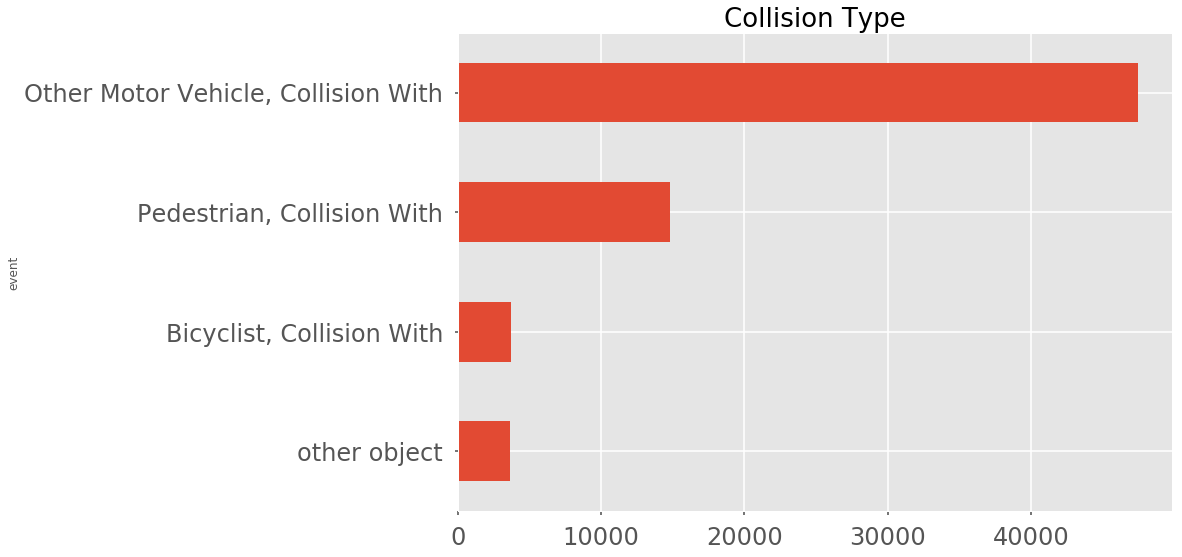

In [8]:
linked.fillna('other object').groupby(['event']).count()[['CI_ID']]\
.sort_values('CI_ID').plot(kind='barh',legend=False,fontsize=24)

plt.title('Collision Type',fontsize=26)

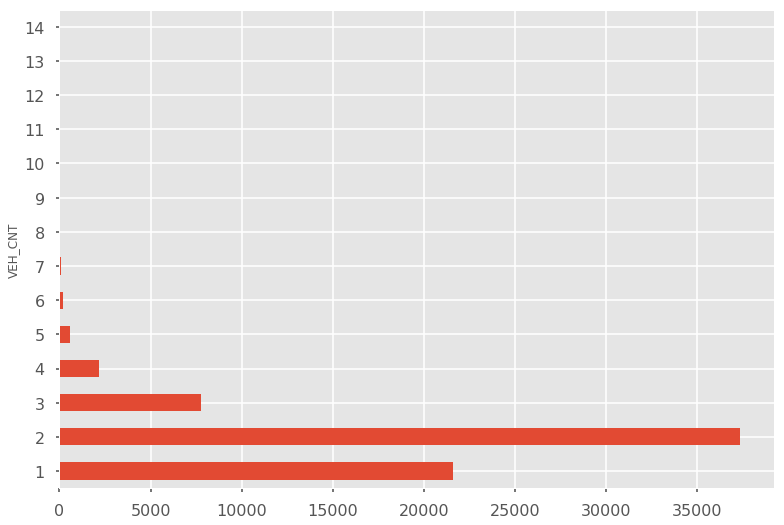

In [9]:
linked.groupby(linked.VEH_CNT.astype(int)).count()[['CI_ID']].plot(kind='barh',
                                                                   legend=False,
                                                                   )

none is unknown vehicle - I'm guessing these are hit and runs? or maybe the cop doesn't always record the vehicle and driver info?

In [11]:
ped[ped.CI_SEX_CDE_driver=='unknown'].groupby(ped.f_OtherVehTypeVIN).count()[['CI_ID']]

,CI_ID
f_OtherVehTypeVIN,
Bus,1
Car,340
Minivan,8
Pickup,3
SUV,88
Truck,4
Van,35
unknown,3042


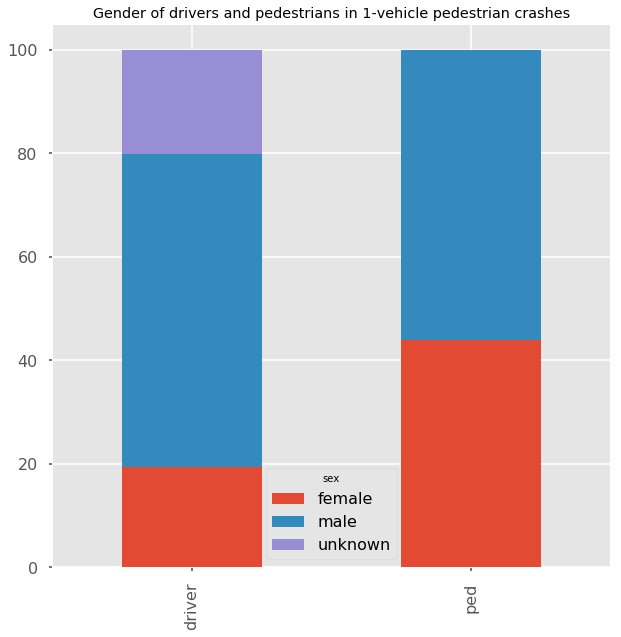

In [12]:
title = 'Gender of drivers and pedestrians in 1-vehicle pedestrian crashes'
pedSexCount = ped.groupby('f_Sex').count()[['CI_ID']]/ped.shape[0]*100
pedSexCount.columns=['ped']
pedSexCount.index.name = 'sex'

driverSexCount = ped.groupby('f_DriverSex').count()[['CI_ID']]/ped.shape[0]*100
driverSexCount.columns = ['driver']
driverSexCount.index.name = 'sex'
driverSexCount.join(pedSexCount).T.plot(kind='bar',
                                        stacked=True,
                                        figsize=(10,10),title=title)

In [13]:
driverSexCount.join(pedSexCount)#.T.plot(kind='bar',stacked=True,figsize=(10,6))

,driver,ped
sex,,
female,19.428053,43.894689
male,60.485701,56.105311
unknown,20.086246,NaN


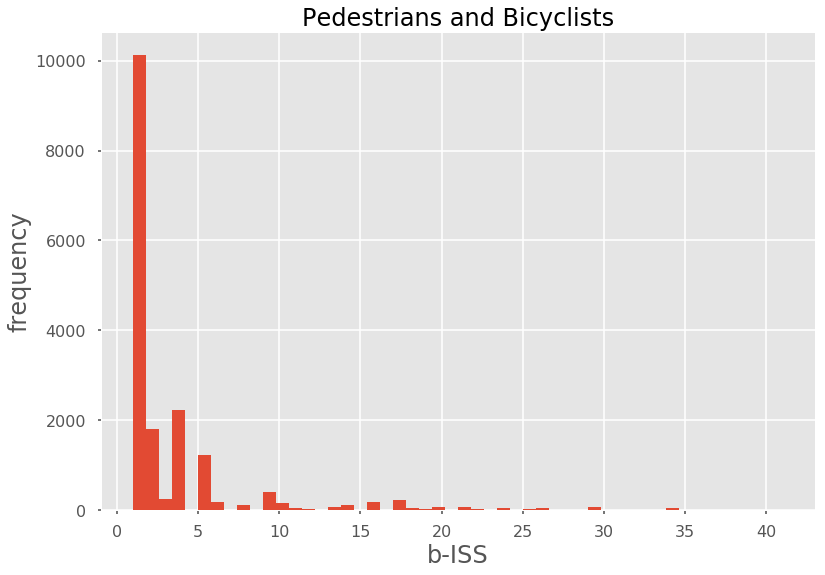

In [14]:
ped.hosp_biss.hist(bins=50)
plt.ylabel('frequency',fontsize=24)
plt.xlabel('b-ISS',fontsize=24)
plt.title('Pedestrians and Bicyclists',fontsize=24)

In [15]:
ped.shape

(17624, 106)

In [16]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,15916
True,1708


In [17]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,16725
True,899


In [18]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.903087
True,0.096913


In [19]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.94899
True,0.05101


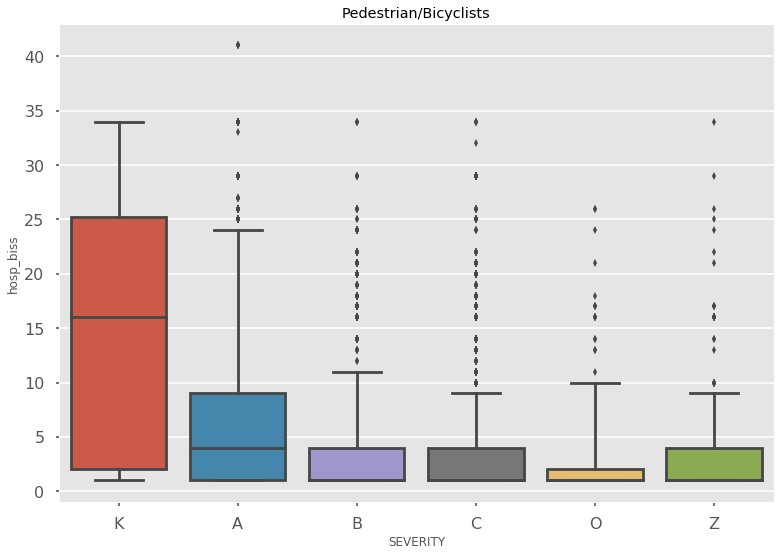

In [20]:
import seaborn as sns

sns.boxplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'], whis=[5,95]
           ).set_title('Pedestrian/Bicyclists')

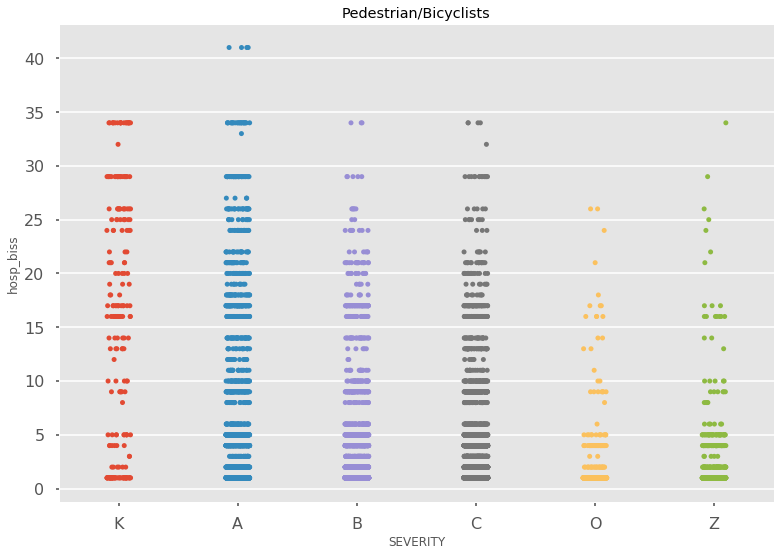

In [21]:
sns.stripplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'],jitter=True
           ).set_title('Pedestrian/Bicyclists')

In [22]:
ped.groupby('SEVERITY').count()[['CI_ID']]

,CI_ID
SEVERITY,
A,2205
B,3890
C,10452
K,220
O,326
Z,531


In [23]:
ped['kabco'] = ped[ped.SEVERITY.isin(['B','C','O'])].SEVERITY
ped.loc[ped.SEVERITY.isin(['K','A']),'kabco']='K/A'
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


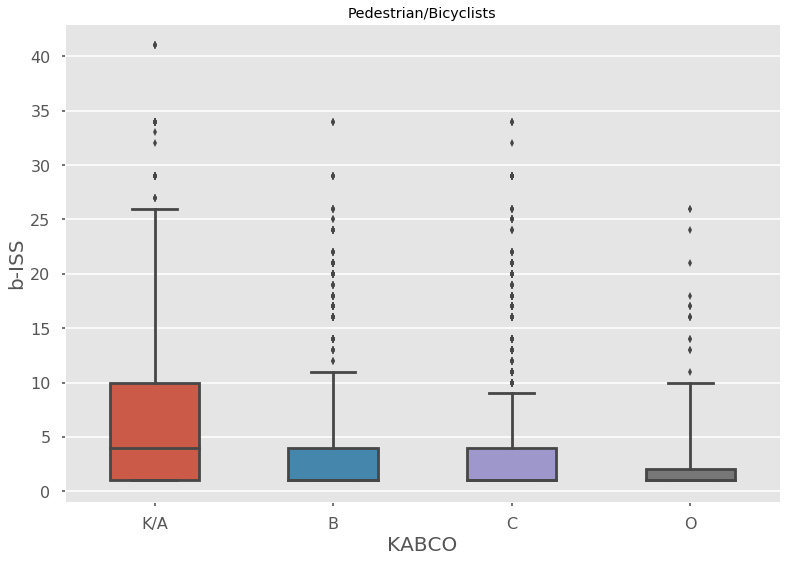

In [24]:
sns.boxplot(x='kabco',y='hosp_biss',
            data=ped,order=['K/A','B','C','O'], whis=[5,95],width=.5
           ).set_title('Pedestrian/Bicyclists')
plt.ylabel('b-ISS',fontsize=20)
plt.xlabel('KABCO',fontsize=20)

In [25]:
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


In [26]:
ct = pd.crosstab(ped.kabco=='K/A',ped.hosp_biss>8)
ct

hosp_biss,False,True
kabco,,
False,14240,959
True,1676,749


In [27]:
ped.shape[0]

17624